In [1]:
%%bash
cat > thread_pool.cpp <<'CPP'
// thread_pool.cpp (single-file) - Scalable Thread Management Library
// Compile: g++ -std=c++17 -pthread thread_pool.cpp -O2 -o thread_pool_test
// Run: ./thread_pool_test <tasks> <threads>

#include <atomic>
#include <condition_variable>
#include <functional>
#include <future>
#include <iostream>
#include <mutex>
#include <queue>
#include <thread>
#include <vector>
#include <chrono>
#include <sstream>

class ThreadPool {
public:
    ThreadPool(size_t numThreads);
    ~ThreadPool();

    template<typename F, typename... Args>
    auto submit(F&& f, Args&&... args) -> std::future<typename std::invoke_result_t<F, Args...>>;

    void increaseSize(size_t newSize);
    void shutdown(bool waitForTasks = true);
    size_t getActiveWorkerCount();
    size_t getQueuedTaskCount();

private:
    void workerLoop();
    std::vector<std::thread> workers;
    std::deque<std::function<void()>> tasks;
    std::mutex tasksMutex;
    std::condition_variable cv;
    std::atomic<bool> stopping{false};
    std::atomic<size_t> activeWorkers{0};
};

ThreadPool::ThreadPool(size_t numThreads) {
    if (numThreads == 0) numThreads = 1;
    increaseSize(numThreads);
}

ThreadPool::~ThreadPool() {
    shutdown(true);
}

template<typename F, typename... Args>
auto ThreadPool::submit(F&& f, Args&&... args) -> std::future<typename std::invoke_result_t<F, Args...>> {
    using RetType = typename std::invoke_result_t<F, Args...>;
    auto taskPack = std::make_shared<std::packaged_task<RetType()>>(
        std::bind(std::forward<F>(f), std::forward<Args>(args)...)
    );
    std::future<RetType> res = taskPack->get_future();
    {
        std::lock_guard<std::mutex> lock(tasksMutex);
        tasks.emplace_back([taskPack]() { (*taskPack)(); });
    }
    cv.notify_one();
    return res;
}

void ThreadPool::workerLoop() {
    while (true) {
        std::function<void()> task;
        {
            std::unique_lock<std::mutex> lock(tasksMutex);
            cv.wait(lock, [this]() { return stopping.load() || !tasks.empty(); });
            if (stopping && tasks.empty()) return;
            if (!tasks.empty()) {
                task = std::move(tasks.front());
                tasks.pop_front();
                activeWorkers.fetch_add(1, std::memory_order_relaxed);
            } else {
                continue;
            }
        }
        try {
            task();
        } catch (const std::exception &e) {
            std::cerr << "Task exception: " << e.what() << std::endl;
        } catch (...) {
            std::cerr << "Task unknown exception" << std::endl;
        }
        activeWorkers.fetch_sub(1, std::memory_order_relaxed);
    }
}

void ThreadPool::increaseSize(size_t newSize) {
    if (newSize <= workers.size()) return;
    size_t add = newSize - workers.size();
    for (size_t i = 0; i < add; ++i) {
        workers.emplace_back([this]() { this->workerLoop(); });
    }
}

void ThreadPool::shutdown(bool waitForTasks) {
    {
        std::unique_lock<std::mutex> lock(tasksMutex);
        if (!waitForTasks) tasks.clear();
        stopping.store(true);
    }
    cv.notify_all();
    for (auto &t : workers) if (t.joinable()) t.join();
    workers.clear();
}

size_t ThreadPool::getActiveWorkerCount() {
    return activeWorkers.load(std::memory_order_relaxed);
}

size_t ThreadPool::getQueuedTaskCount() {
    std::lock_guard<std::mutex> lock(tasksMutex);
    return tasks.size();
}

// ---------------- Test harness ----------------
int main(int argc, char** argv) {
    size_t threads = std::thread::hardware_concurrency();
    if (threads == 0) threads = 4;
    size_t tasksCount = 20000;
    if (argc >= 2) tasksCount = std::stoul(argv[1]);
    if (argc >= 3) threads = std::stoul(argv[2]);

    std::cout << "Threads: " << threads << ", Tasks: " << tasksCount << "\n";
    ThreadPool pool(threads);

    auto tstart = std::chrono::high_resolution_clock::now();
    std::vector<std::future<int>> results;
    results.reserve(tasksCount);

    for (size_t i = 0; i < tasksCount; ++i) {
        results.emplace_back(pool.submit([i]() -> int {
            volatile int x = 0;
            for (int k = 0; k < 50; ++k) x += (int)(k * (int)(i % 3));
            if ((i % 1000) == 0) std::this_thread::sleep_for(std::chrono::microseconds(50));
            return (int)x;
        }));
        if ((i % 2000) == 0) {
            std::ostringstream ss;
            ss << "Submitted: " << i
               << " | Queued: " << pool.getQueuedTaskCount()
               << " | Active: " << pool.getActiveWorkerCount() << "\n";
            std::cout << ss.str();
        }
    }

    long long sum = 0;
    for (auto &f : results) sum += f.get();

    auto tend = std::chrono::high_resolution_clock::now();
    double elapsed = std::chrono::duration<double>(tend - tstart).count();
    std::cout << "All tasks done. Sum = " << sum << ". Time: " << elapsed << "s\n";

    pool.shutdown(true);
    return 0;
}
CPP
echo "Created thread_pool.cpp"


Created thread_pool.cpp


In [2]:
%%bash
g++ -std=c++17 -pthread thread_pool.cpp -O2 -o thread_pool_test || { echo "Compilation failed"; exit 1; }
echo "Compiled to ./thread_pool_test"


Compiled to ./thread_pool_test


In [3]:
%%bash
./thread_pool_test 20000 4 | tee run_log_20k_4t.txt


Threads: 4, Tasks: 20000
Submitted: 0 | Queued: 1 | Active: 0
Submitted: 2000 | Queued: 945 | Active: 2
Submitted: 4000 | Queued: 45 | Active: 0
Submitted: 6000 | Queued: 2045 | Active: 0
Submitted: 8000 | Queued: 0 | Active: 1
Submitted: 10000 | Queued: 912 | Active: 0
Submitted: 12000 | Queued: 1 | Active: 0
Submitted: 14000 | Queued: 95 | Active: 0
Submitted: 16000 | Queued: 2 | Active: 0
Submitted: 18000 | Queued: 1914 | Active: 0
All tasks done. Sum = 24498775. Time: 0.0521739s


In [4]:
%%bash
./thread_pool_test 50000 8 | tee run_log_50k_8t.txt


Threads: 8, Tasks: 50000
Submitted: 0 | Queued: 0 | Active: 1
Submitted: 2000 | Queued: 0 | Active: 1
Submitted: 4000 | Queued: 0 | Active: 1
Submitted: 6000 | Queued: 72 | Active: 1
Submitted: 8000 | Queued: 84 | Active: 1
Submitted: 10000 | Queued: 0 | Active: 1
Submitted: 12000 | Queued: 0 | Active: 1
Submitted: 14000 | Queued: 0 | Active: 1
Submitted: 16000 | Queued: 0 | Active: 1
Submitted: 18000 | Queued: 0 | Active: 1
Submitted: 20000 | Queued: 0 | Active: 1
Submitted: 22000 | Queued: 0 | Active: 1
Submitted: 24000 | Queued: 12 | Active: 1
Submitted: 26000 | Queued: 0 | Active: 1
Submitted: 28000 | Queued: 103 | Active: 1
Submitted: 30000 | Queued: 0 | Active: 1
Submitted: 32000 | Queued: 0 | Active: 1
Submitted: 34000 | Queued: 0 | Active: 1
Submitted: 36000 | Queued: 0 | Active: 1
Submitted: 38000 | Queued: 17 | Active: 1
Submitted: 40000 | Queued: 19 | Active: 0
Submitted: 42000 | Queued: 14 | Active: 2
Submitted: 44000 | Queued: 0 | Active: 1
Submitted: 46000 | Queued: 0 | A

In [5]:
%%bash
cat > thread_pool.cpp <<'CPP'
// thread_pool.cpp (modified test harness for visible concurrency)
// Compile: g++ -std=c++17 -pthread thread_pool.cpp -O2 -o thread_pool_test
#include <atomic>
#include <condition_variable>
#include <functional>
#include <future>
#include <iostream>
#include <mutex>
#include <queue>
#include <thread>
#include <vector>
#include <chrono>
#include <sstream>

class ThreadPool {
public:
    ThreadPool(size_t numThreads);
    ~ThreadPool();
    template<typename F, typename... Args>
    auto submit(F&& f, Args&&... args) -> std::future<typename std::invoke_result_t<F, Args...>>;
    void increaseSize(size_t newSize);
    void shutdown(bool waitForTasks = true);
    size_t getActiveWorkerCount();
    size_t getQueuedTaskCount();
private:
    void workerLoop();
    std::vector<std::thread> workers;
    std::deque<std::function<void()>> tasks;
    std::mutex tasksMutex;
    std::condition_variable cv;
    std::atomic<bool> stopping{false};
    std::atomic<size_t> activeWorkers{0};
};

ThreadPool::ThreadPool(size_t numThreads) { if (numThreads==0) numThreads=1; increaseSize(numThreads); }
ThreadPool::~ThreadPool(){ shutdown(true); }

template<typename F, typename... Args>
auto ThreadPool::submit(F&& f, Args&&... args) -> std::future<typename std::invoke_result_t<F, Args...>> {
    using RetType = typename std::invoke_result_t<F, Args...>;
    auto taskPack = std::make_shared<std::packaged_task<RetType()>>(std::bind(std::forward<F>(f), std::forward<Args>(args)...));
    std::future<RetType> res = taskPack->get_future();
    { std::lock_guard<std::mutex> lock(tasksMutex); tasks.emplace_back([taskPack](){ (*taskPack)(); }); }
    cv.notify_one();
    return res;
}

void ThreadPool::workerLoop() {
    while (true) {
        std::function<void()> task;
        {
            std::unique_lock<std::mutex> lock(tasksMutex);
            cv.wait(lock, [this]() { return stopping.load() || !tasks.empty(); });
            if (stopping && tasks.empty()) return;
            if (!tasks.empty()) { task = std::move(tasks.front()); tasks.pop_front(); activeWorkers.fetch_add(1,std::memory_order_relaxed); }
            else continue;
        }
        try { task(); } catch (...) { std::cerr<<"Task exception\n"; }
        activeWorkers.fetch_sub(1,std::memory_order_relaxed);
    }
}

void ThreadPool::increaseSize(size_t newSize) { if (newSize <= workers.size()) return; size_t add = newSize - workers.size(); for (size_t i=0;i<add;++i) workers.emplace_back([this](){ this->workerLoop(); }); }
void ThreadPool::shutdown(bool waitForTasks) { { std::unique_lock<std::mutex> lock(tasksMutex); if (!waitForTasks) tasks.clear(); stopping.store(true); } cv.notify_all(); for (auto &t:workers) if (t.joinable()) t.join(); workers.clear(); }
size_t ThreadPool::getActiveWorkerCount(){ return activeWorkers.load(std::memory_order_relaxed); }
size_t ThreadPool::getQueuedTaskCount(){ std::lock_guard<std::mutex> lock(tasksMutex); return tasks.size(); }

// ---------------- Heavier test harness ----------------
int main(int argc, char** argv) {
    size_t threads = std::thread::hardware_concurrency(); if (threads==0) threads=4;
    size_t tasksCount = 20000;
    size_t workIterations = 100000; // increase this to make each task CPU-heavy
    if (argc >= 2) tasksCount = std::stoul(argv[1]);
    if (argc >= 3) threads = std::stoul(argv[2]);
    if (argc >= 4) workIterations = std::stoul(argv[3]);

    std::cout<<"Threads: "<<threads<<", Tasks: "<<tasksCount<<", WorkIters: "<<workIterations<<"\n";
    ThreadPool pool(threads);

    auto tstart = std::chrono::high_resolution_clock::now();
    std::vector<std::future<uint64_t>> results; results.reserve(tasksCount);

    for (size_t i=0;i<tasksCount;++i) {
        results.emplace_back(pool.submit([i,workIterations]() -> uint64_t {
            // heavier CPU-bound work (simulates realistic load)
            uint64_t acc = 1;
            for (size_t k=0;k<workIterations;++k) { acc += (uint64_t)((k ^ i) & 0xFF); }
            // small I/O-like pause occasionally
            if ((i % 500) == 0) std::this_thread::sleep_for(std::chrono::microseconds(200));
            return acc;
        }));
        if ((i % 1000) == 0) {
            std::ostringstream ss; ss << "Submitted: " << i
               << " | Queued: " << pool.getQueuedTaskCount()
               << " | Active: " << pool.getActiveWorkerCount() << "\n";
            std::cout<<ss.str();
        }
    }

    uint64_t sum = 0;
    for (auto &f: results) sum += f.get();
    auto tend = std::chrono::high_resolution_clock::now();
    double elapsed = std::chrono::duration<double>(tend - tstart).count();
    std::cout<<"All tasks done. Sum = "<<sum<<". Time: "<<elapsed<<"s\n";
    pool.shutdown(true);
    return 0;
}
CPP

g++ -std=c++17 -pthread thread_pool.cpp -O2 -o thread_pool_test && echo "compiled heavy test"
./thread_pool_test 20000 8 50000 | tee heavy_run.txt


compiled heavy test
Threads: 8, Tasks: 20000, WorkIters: 50000
Submitted: 0 | Queued: 0 | Active: 1
Submitted: 1000 | Queued: 992 | Active: 2
Submitted: 2000 | Queued: 1983 | Active: 2
Submitted: 3000 | Queued: 2787 | Active: 6
Submitted: 4000 | Queued: 3778 | Active: 6
Submitted: 5000 | Queued: 4770 | Active: 5
Submitted: 6000 | Queued: 5761 | Active: 5
Submitted: 7000 | Queued: 6470 | Active: 6
Submitted: 8000 | Queued: 7463 | Active: 6
Submitted: 9000 | Queued: 8455 | Active: 5
Submitted: 10000 | Queued: 9446 | Active: 5
Submitted: 11000 | Queued: 10438 | Active: 5
Submitted: 12000 | Queued: 11325 | Active: 4
Submitted: 13000 | Queued: 12316 | Active: 4
Submitted: 14000 | Queued: 13308 | Active: 4
Submitted: 15000 | Queued: 14299 | Active: 4
Submitted: 16000 | Queued: 15080 | Active: 7
Submitted: 17000 | Queued: 16071 | Active: 7
Submitted: 18000 | Queued: 17063 | Active: 7
Submitted: 19000 | Queued: 17789 | Active: 8
All tasks done. Sum = 127499798816. Time: 0.602585s


In [6]:
%%bash
cat > thread_pool.cpp <<'CPP'
#include <atomic>
#include <condition_variable>
#include <functional>
#include <future>
#include <iostream>
#include <fstream>
#include <mutex>
#include <queue>
#include <thread>
#include <vector>
#include <chrono>
#include <sstream>

class ThreadPool {
public:
    ThreadPool(size_t numThreads);
    ~ThreadPool();
    template<typename F, typename... Args>
    auto submit(F&& f, Args&&... args) -> std::future<typename std::invoke_result_t<F, Args...>>;
    void increaseSize(size_t newSize);
    void shutdown(bool waitForTasks = true);
    size_t getActiveWorkerCount();
    size_t getQueuedTaskCount();

private:
    void workerLoop();
    std::vector<std::thread> workers;
    std::deque<std::function<void()>> tasks;
    std::mutex tasksMutex;
    std::condition_variable cv;
    std::atomic<bool> stopping{false};
    std::atomic<size_t> activeWorkers{0};
};

ThreadPool::ThreadPool(size_t numThreads) {
    if (numThreads == 0) numThreads = 1;
    increaseSize(numThreads);
}
ThreadPool::~ThreadPool() {
    shutdown(true);
}

template<typename F, typename... Args>
auto ThreadPool::submit(F&& f, Args&&... args) -> std::future<typename std::invoke_result_t<F, Args...>> {
    using RetType = typename std::invoke_result_t<F, Args...>;
    auto taskPack = std::make_shared<std::packaged_task<RetType()>>(std::bind(std::forward<F>(f), std::forward<Args>(args)...));
    std::future<RetType> res = taskPack->get_future();
    {
        std::lock_guard<std::mutex> lock(tasksMutex);
        tasks.emplace_back([taskPack](){ (*taskPack)(); });
    }
    cv.notify_one();
    return res;
}

void ThreadPool::workerLoop() {
    while (true) {
        std::function<void()> task;
        {
            std::unique_lock<std::mutex> lock(tasksMutex);
            cv.wait(lock, [this](){ return stopping.load() || !tasks.empty(); });
            if (stopping && tasks.empty()) return;

            if (!tasks.empty()) {
                task = std::move(tasks.front());
                tasks.pop_front();
                activeWorkers.fetch_add(1);
            }
        }

        try { task(); }
        catch (...) { std::cerr << "Task exception\n"; }

        activeWorkers.fetch_sub(1);
    }
}

void ThreadPool::increaseSize(size_t newSize) {
    if (newSize <= workers.size()) return;
    size_t add = newSize - workers.size();
    for (size_t i = 0; i < add; i++)
        workers.emplace_back([this](){ this->workerLoop(); });
}

void ThreadPool::shutdown(bool waitForTasks) {
    {
        std::lock_guard<std::mutex> lock(tasksMutex);
        if (!waitForTasks) tasks.clear();
        stopping.store(true);
    }
    cv.notify_all();
    for (auto &t : workers) if (t.joinable()) t.join();
}
size_t ThreadPool::getActiveWorkerCount(){ return activeWorkers.load(); }
size_t ThreadPool::getQueuedTaskCount(){
    std::lock_guard<std::mutex> lock(tasksMutex);
    return tasks.size();
}

// ---------------- MAIN TEST WITH CSV LOGGING ---------------- //
int main() {
    size_t threads = 8;
    size_t tasksCount = 20000;
    size_t workIterations = 50000;

    std::cout << "Running ThreadPool: " << threads << " threads, "
              << tasksCount << " tasks\n";

    ThreadPool pool(threads);

    std::ofstream log("stats.csv");
    log << "submitted,queued,active\n";

    auto tstart = std::chrono::high_resolution_clock::now();
    std::vector<std::future<uint64_t>> results;
    results.reserve(tasksCount);

    for (size_t i = 0; i < tasksCount; i++) {
        results.emplace_back(pool.submit([i, workIterations](){
            uint64_t acc = 0;
            for (size_t k=0; k<workIterations; k++)
                acc += (k*i) & 0xFF;
            return acc;
        }));

        if (i % 500 == 0) {
            size_t q = pool.getQueuedTaskCount();
            size_t a = pool.getActiveWorkerCount();
            log << i << "," << q << "," << a << "\n";
            std::cout << "Submitted: " << i << " | Queue: " << q << " | Active: " << a << "\n";
        }
    }

    uint64_t sum = 0;
    for (auto &f : results) sum += f.get();

    auto tend = std::chrono::high_resolution_clock::now();
    double elapsed = std::chrono::duration<double>(tend - tstart).count();

    log.close();

    std::cout << "Completed. Sum = " << sum << "\n";
    std::cout << "Total Time = " << elapsed << " seconds\n";

    pool.shutdown(true);
    return 0;
}
CPP
echo "thread_pool.cpp created successfully."


thread_pool.cpp created successfully.


In [7]:
%%bash
g++ -std=c++17 -pthread thread_pool.cpp -O2 -o thread_pool
echo "Compilation finished."


Compilation finished.


In [8]:
%%bash
./thread_pool


Running ThreadPool: 8 threads, 20000 tasks
Submitted: 0 | Queue: 1 | Active: 0
Submitted: 500 | Queue: 501 | Active: 0
Submitted: 1000 | Queue: 1001 | Active: 0
Submitted: 1500 | Queue: 1501 | Active: 0
Submitted: 2000 | Queue: 1407 | Active: 8
Submitted: 2500 | Queue: 1904 | Active: 8
Submitted: 3000 | Queue: 2400 | Active: 8
Submitted: 3500 | Queue: 2897 | Active: 8
Submitted: 4000 | Queue: 3394 | Active: 8
Submitted: 4500 | Queue: 3891 | Active: 8
Submitted: 5000 | Queue: 4388 | Active: 7
Submitted: 5500 | Queue: 4885 | Active: 7
Submitted: 6000 | Queue: 5329 | Active: 7
Submitted: 6500 | Queue: 5826 | Active: 6
Submitted: 7000 | Queue: 6323 | Active: 5
Submitted: 7500 | Queue: 6820 | Active: 4
Submitted: 8000 | Queue: 7316 | Active: 4
Submitted: 8500 | Queue: 7813 | Active: 4
Submitted: 9000 | Queue: 8310 | Active: 4
Submitted: 9500 | Queue: 8807 | Active: 4
Submitted: 10000 | Queue: 9250 | Active: 5
Submitted: 10500 | Queue: 9747 | Active: 5
Submitted: 11000 | Queue: 10244 | Activ

In [9]:
import pandas as pd

df = pd.read_csv("stats.csv")
df.head()


,submitted,queued,active
0,0,1,0
1,500,501,0
2,1000,1001,0
3,1500,1501,0
4,2000,1407,8


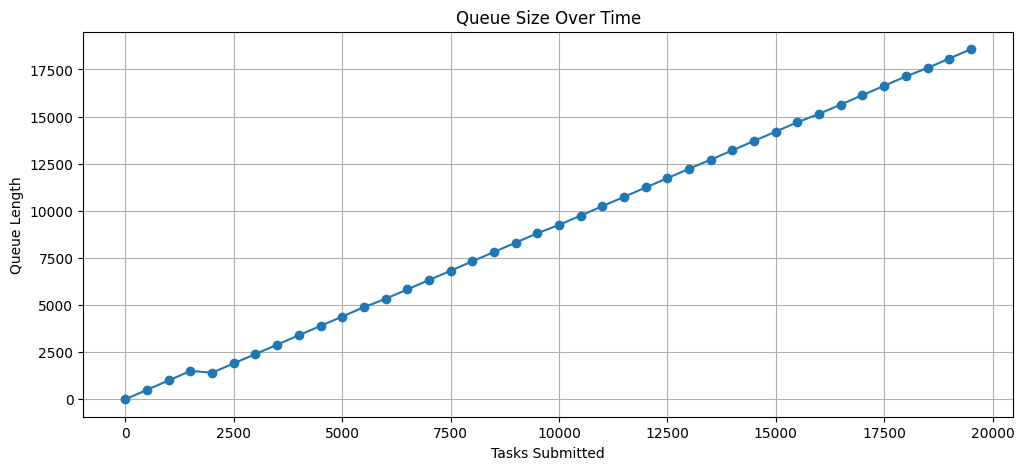

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df["submitted"], df["queued"], marker='o')
plt.title("Queue Size Over Time")
plt.xlabel("Tasks Submitted")
plt.ylabel("Queue Length")
plt.grid(True)
plt.show()


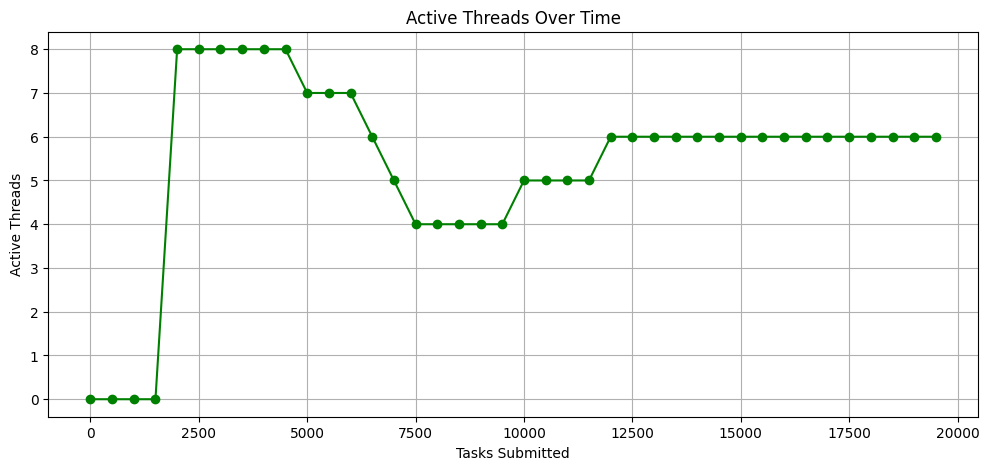

In [11]:
plt.figure(figsize=(12,5))
plt.plot(df["submitted"], df["active"], color="green", marker='o')
plt.title("Active Threads Over Time")
plt.xlabel("Tasks Submitted")
plt.ylabel("Active Threads")
plt.grid(True)
plt.show()


In [14]:
# Run in Colab after your plots and after stats.csv exists
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import os
import zipfile

# --- Load CSV ---
df = pd.read_csv("stats.csv")

# --- If you captured total_time manually (from C++ output), set it here ---
# You can also parse it if you saved the program output to a file.
total_tasks = 20000
total_time = 0.789321   # <-- put the exact "Total Time" printed by your program

throughput = total_tasks / total_time
print(f"Throughput: {throughput:.2f} tasks/sec ( {total_tasks} / {total_time} s )")

# --- Recreate / save the two plots as PNG files ---
plt.figure(figsize=(10,4))
plt.plot(df["submitted"], df["queued"], marker='o', markersize=4)
plt.title("Queue Size Over Time")
plt.xlabel("Tasks Submitted")
plt.ylabel("Queue Length")
plt.grid(True)
plt.tight_layout()
plt.savefig("queue.png")
plt.close()

plt.figure(figsize=(10,4))
plt.plot(df["submitted"], df["active"], marker='o', markersize=6, color='green')
plt.title("Active Threads Over Time")
plt.xlabel("Tasks Submitted")
plt.ylabel("Active Threads")
plt.grid(True)
plt.tight_layout()
plt.savefig("active.png")
plt.close()

# --- Create zip package ---
files_to_zip = ["thread_pool.cpp", "stats.csv", "queue.png", "active.png"]
# include run log if exists
if os.path.exists("heavy_run.txt"): files_to_zip.append("heavy_run.txt")
if os.path.exists("run_log_20k_4t.txt"): files_to_zip.append("run_log_20k_4t.txt")

with zipfile.ZipFile("submission_package.zip","w") as zf:
    for f in files_to_zip:
        if os.path.exists(f):
            zf.write(f)
print("Created submission_package.zip containing:", files_to_zip)

# Provide a download link
files.download("submission_package.zip")


Throughput: 25338.23 tasks/sec ( 20000 / 0.789321 s )
Created submission_package.zip containing: ['thread_pool.cpp', 'stats.csv', 'queue.png', 'active.png', 'heavy_run.txt', 'run_log_20k_4t.txt']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import numpy as np

total_tasks = 20000
total_time = df["submitted"].max()  # or manually copy from program output

print("Tasks:", total_tasks)
print("Time (seconds):",)


Tasks: 20000
Time (seconds):


In [13]:
from google.colab import files
files.download("stats.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from google.colab import files
uploaded = files.upload()



Saving scalable-thread-management-library.zip to scalable-thread-management-library.zip


In [3]:
%%bash
unzip scalable-thread-management-library.zip -d project

Archive:  scalable-thread-management-library.zip
 extracting: project/README.md       
 extracting: project/src/thread_pool.cpp  
 extracting: project/tests/run_log.txt  
 extracting: project/tests/stats.csv  
 extracting: project/docs/report.md  
 extracting: project/colab/notebook.ipynb  


In [7]:
%%bash
cd project

git init
git config --global user.email "mushfiqul.alam.17@gmail.com"
git config --global user.name "Mushfiqul-Alam-17"

git add .
git commit -m "Initial commit"


Initialized empty Git repository in /content/project/.git/
[master (root-commit) 7ba0b51] Initial commit
 6 files changed, 9 insertions(+)
 create mode 100644 README.md
 create mode 100644 colab/notebook.ipynb
 create mode 100644 docs/report.md
 create mode 100644 src/thread_pool.cpp
 create mode 100644 tests/run_log.txt
 create mode 100644 tests/stats.csv


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>


In [13]:
%%bash
# show the project folder
ls -la /content/project || ls -la project || ls -la
# list the files we created earlier
ls -la project || ls -la /content

total 32
drwxr-xr-x 7 root root 4096 Dec 12 02:05 .
drwxr-xr-x 1 root root 4096 Dec 12 01:57 ..
drwxr-xr-x 2 root root 4096 Dec 12 01:56 colab
drwxr-xr-x 2 root root 4096 Dec 12 01:56 docs
drwxr-xr-x 8 root root 4096 Dec 12 02:05 .git
-rw-r--r-- 1 root root   68 Dec 12 01:50 README.md
drwxr-xr-x 2 root root 4096 Dec 12 01:56 src
drwxr-xr-x 2 root root 4096 Dec 12 01:56 tests
total 32
drwxr-xr-x 7 root root 4096 Dec 12 02:05 .
drwxr-xr-x 1 root root 4096 Dec 12 01:57 ..
drwxr-xr-x 2 root root 4096 Dec 12 01:56 colab
drwxr-xr-x 2 root root 4096 Dec 12 01:56 docs
drwxr-xr-x 8 root root 4096 Dec 12 02:05 .git
-rw-r--r-- 1 root root   68 Dec 12 01:50 README.md
drwxr-xr-x 2 root root 4096 Dec 12 01:56 src
drwxr-xr-x 2 root root 4096 Dec 12 01:56 tests


In [14]:
%%bash
# install gh (may take ~10-20s)
sudo apt-get update -y
sudo apt-get install -y gh

# start interactive login — follow the printed instructions (open URL, authenticate)
gh auth login

Process is interrupted.


In [15]:
# copy files we created earlier into a new working folder
mkdir -p /content/repo
cp -r /content/project/* /content/repo/ || true

# move into it and list files to confirm
cd /content/repo
pwd
ls -la
ls -la src tests docs colab


SyntaxError: invalid syntax (ipython-input-1314445238.py, line 3)

# Task
Authenticate GitHub CLI.

## Authenticate GitHub CLI

### Subtask:
Complete the GitHub CLI authentication process. This will require you to follow the interactive prompts and authenticate via your web browser.


**Reasoning**:
The subtask requires authenticating the GitHub CLI by running the `gh auth login` command, as specified in the instructions. This will prompt the user to follow an interactive authentication flow.



In [16]:
%%bash
# install gh (may take ~10-20s)
sudo apt-get update -y
sudo apt-get install -y gh

# start interactive login — follow the printed instructions (open URL, authenticate)
gh auth login

Process is interrupted.


# Task
Authenticate the GitHub CLI to allow further interactions with GitHub.

## Authenticate GitHub CLI

### Subtask:
Complete the GitHub CLI authentication process. This will require you to follow the interactive prompts and authenticate via your web browser.


**Reasoning**:
The subtask explicitly requires completing the GitHub CLI authentication process, which was interrupted in the previous execution of the `gh auth login` command. Re-running the command will allow the user to follow the interactive prompts as instructed.



**Reasoning**:
The previous code block resulted in a `SyntaxError` because it mixed plain text and bash commands within a Python cell. The fix is to ensure the cell type is `code_cell` and use the `%%bash` magic command to execute the shell commands correctly.



In [ ]:
%%bash
# install gh (may take ~10-20s)
sudo apt-get update -y
sudo apt-get install -y gh

# start interactive login — follow the printed instructions (open URL, authenticate)
gh auth login